In [1]:
import random
import numpy as np
random.seed(1)
def gen_time_series(length=100, lower_bound=0, upper_bound=1 ):
    for item in range(length):
        yield (upper_bound-lower_bound)*random.random()+lower_bound;

ts = [item for item in gen_time_series()]

# normalize the time series
def normalize(time_series):
    time_series = np.array(time_series)
    # print 'mean:', round(np.mean(time_serie),3) ,'std:', np.std(time_serie)
    return (time_series-np.mean(time_series))/np.std(time_series)
    
ts = normalize(ts)
assert set(np.isclose(ts,normalize(ts))) == set([True]) # Works 

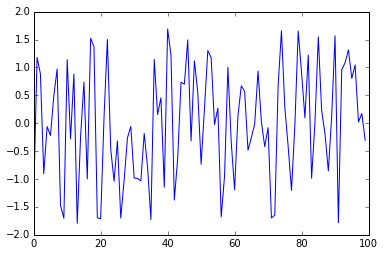

In [2]:
# plotting the TS
import matplotlib.pyplot as plt
%matplotlib inline  
plt.plot(range(len(ts)),ts)


## PAA implementation and visualization elements

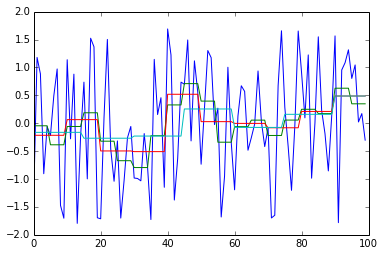

In [3]:
# yield time series by word 
def segment(time_series, word_size=10):
    word = []
    for item in time_series:
        word.append(item)
        if len(word)== word_size:
            yield word
            word = [] # reinit the word
    if len(word):
        yield word # emit the last word 

def paa_proj(time_series, word_size=10):
    """ Reproduce an identical length as input time series (while each item is projected to the pss)
    for plotting pupose"""
    paa_ts = []
    for word in segment(time_series, word_size=word_size):
        paa_ts.extend([np.mean(word) for _ in range(len(word))])
    return paa_ts

def paa(time_series, word_size=10):
    """ Real PAA reducing the dimension (length) of the time series"""
    paa_ts = []
    for word in segment(time_series, word_size=word_size):
        paa_ts.append(np.mean(word))
    return paa_ts


plt.plot(range(len(ts)),ts)
plt.plot(range(len(ts)), paa_proj(ts, word_size=5))
plt.plot(range(len(ts)), paa_proj(ts))
plt.plot(range(len(ts)), paa_proj(ts, word_size=15))


## SAX implementation

In this section you find a SAX implementation as well as the symbols frequency dict and more ...
it implements the elements that answers the question : "translate the time series into its symbolic representation using SAX, and compute the frequency of each SAX symbol in this representation."

### Some notes

According to the "It is desirable to have a discretization technique that will produce symbols with equiprobability" [iSAX paper]:

Because SAX doesn't provide this that much especially for no-trend times series (that what I remarked extracting) the frequency/distribution of symbols. In fact  the paper(s) tell that we should normalize before applying the PAA, while the PAA reduces the variance we loose representation of border symbols (Symbols which represents both distribution tails). However the symmetry of the Normal distribution ensures the "equiprobabilty" between the positive and negative side of the gaussian Bell. In other word for caridinalty == 2 (word_size==2), we have surely the equiprobability of symbols (the two symbols).


In [4]:
from scipy.stats import norm
from pprint import pprint

# Some useful helpers

def to_prob(freq_dict):
    """ Transforms freq. dict. to a probability distribution"""
    omega_card = sum(freq_dict.values()) 
    return {key:float(value)/omega_card for key, value in freq_dict.iteritems()}

def get_max_entropy(symbols_card):
    prob = 1./symbols_card
    return -symbols_card*prob*np.log2(prob)

def get_entropy(freq_dict):
    """ Returns entropy: as a plausible way  for comparing (equiprobability), the higher entropy the better. 
    entropy is maxmized for equiprobabilty """
    return -sum([prob*np.log2(prob) for prob in to_prob(freq_dict).values()])

assert get_max_entropy(2) == 1
assert get_entropy ({"bla":5, "blabla":5}) == 1


def get_symbol_freq(sax_ts):
    """ Returns Symbols frequency dict."""
    sym_freq = {}
    for sym in sax_ts:
        sym_freq[sym] = sym_freq.get(sym, 0) + 1
    # print 'Entropy:', get_entropy(sym_freq)
    return sym_freq


def sax(time_series, word_size=4, symbols=['a','b','c','d'], break_points_precision=2, verbose=True):
    """ Generates SAX from time series, iSAX paper and PAA[9] reference """
    
    cummulated_prob_tics = [round(norm.ppf(tic), break_points_precision) for tic in np.arange(0,1, 1./len(symbols))][1:] 
    # that computes break points, optimize projection by removing the lower bound (-inf) since all the items are > -inf 
    sax_ts = [symbols [sum(map(int, (item - cummulated_prob_tics)>0))] \
              for item in  paa(normalize(time_series), word_size=word_size)]
    symbols_freq_dict = get_symbol_freq(sax_ts)
    # Some displays (sort of simple logging) for debug/analyse
    if verbose:
        print 'Break points (just for verification): ', cummulated_prob_tics    
        print 'SAX Rep.:', ''.join(sax_ts)
        print 'Symbols freq dict:', symbols_freq_dict 
        print 'Entropy:', get_entropy(symbols_freq_dict), 'Max entropy:', get_max_entropy(len(symbols))
    return sax_ts 


# A small test
sax_ts = sax(ts)

Break points (just for verification):  [-0.67, 0.0, 0.67]
SAX Rep.: bcbbcbabaccccdbccbcbccbdc
Symbols freq dict: {'a': 2, 'c': 12, 'b': 9, 'd': 2}
Entropy: 1.62190118891 Max entropy: 2.0


Break points (just for verification):  [-0.67, 0.0, 0.67]
SAX Rep.: acbccbcbcccdbabdcbdbcbbac
Symbols freq dict: {'a': 3, 'c': 10, 'b': 9, 'd': 3}
Entropy: 1.79352095113 Max entropy: 2.0


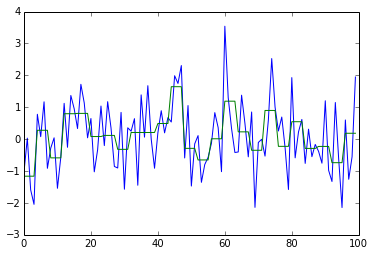

In [5]:
# a 2nd example Normal distribution (non-trend) remark here the entropy and the symbols frequency dict
ts_norm = [item for item in np.random.normal(0, 1, 100)]
plt.plot(range(len(ts_norm)), ts_norm)
plt.plot(range(len(ts_norm)), paa_proj(ts_norm, word_size=4))
# A small test
_ = sax(ts_norm)

Break points (just for verification):  [-0.67, 0.0, 0.67]
SAX Rep.: aaaaaabbbbbbbccccccdddddd
Symbols freq dict: {'a': 6, 'c': 6, 'b': 7, 'd': 6}
Entropy: 1.99662381108 Max entropy: 2.0


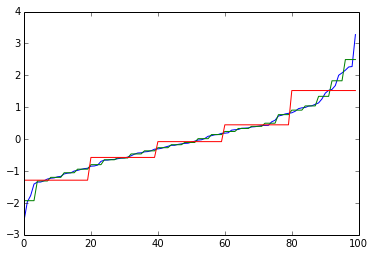

In [6]:
# Normal distribution (sorted to gnenerate trend),
# remark here the higher entropy and the symbols frequency dict
# compared to the previous example

ts_norm = [item for item in sorted(np.random.normal(0, 1, 100))]
plt.plot(range(len(ts_norm)), ts_norm)
plt.plot(range(len(ts_norm)), paa_proj(ts_norm, word_size=4))
plt.plot(range(len(ts_norm)), paa_proj(ts_norm, word_size=20))
# A small test
_ = sax(ts_norm)

Break points (just for verification):  [-0.67, 0.0, 0.67]
SAX Rep.: aaaabbaaccbcdccddddd
Symbols freq dict: {'a': 6, 'c': 5, 'b': 3, 'd': 6}
Entropy: 1.95272419562 Max entropy: 2.0


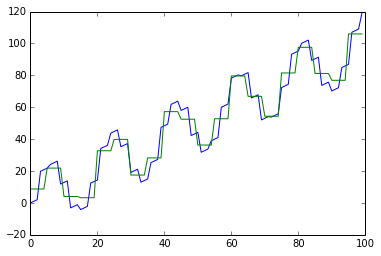

In [13]:
# Another time series example
def gen_time_series_sin(length=100, alpha=1, sin_amp=20, lower_bound=0):
    for item in range(length):
        yield (sin_amp*np.sin(item/3))+(alpha*item)+lower_bound;
        
ts_sin_lin = [item for item in gen_time_series_sin()]
plt.plot(range(len(ts_sin_lin)), ts_sin_lin)
plt.plot(range(len(ts_lin)), paa_proj(ts_sin_lin, word_size=5))
_ = sax(ts_sin_lin, word_size=5)

# iSAX implentation (some elements, to be continued)

In [8]:
# Implenting iSAX
def binary_string(item, bin_digits):
    assert item < (2**bin_digits)
    return "{0:b}".format(item).zfill(bin_digits)


def iSax(time_series, word_size=4, symbols_card=2, break_points_precision=2, verbose=True):
    """ iSax implentation """
    # we have two choices of dealing with the symbols_card either assert that 
    # it is a power of 2 or approximate to the closest (smallest) power_of_2 symbols_card<power_of_2
    assert 2**int(np.log2(symbols_card)) == symbols_card
    to_bin_symbol_card = int (np.log2(symbols_card))
    cummulated_prob_tics = [round(norm.ppf(tic), break_points_precision)\
                            for tic in np.arange(0,1, 1./symbols_card)][1:] 
    sax_ts = [binary_string(sum(map(int, (item - cummulated_prob_tics)>0)), to_bin_symbol_card)\
               for item in  paa(normalize(time_series), word_size=word_size)]
    
    symbols_freq_dict = get_symbol_freq(sax_ts)
    if verbose:
        print 'iSAX Rep.:', ' '.join(sax_ts)
        print 'Symbols freq dict:', symbols_freq_dict 
        print 'Entropy:', get_entropy(symbols_freq_dict), 'Max entropy:', get_max_entropy(symbols_card)
    return sax_ts

isax_nom_4 = iSax(ts_norm, symbols_card=4)
isax_nom_2 = iSax(ts_norm, symbols_card=2)

[item[:1] for item in isax_nom_4] == isax_nom_2

iSAX Rep.: 00 00 00 00 00 00 01 01 01 01 01 01 01 10 10 10 10 10 10 11 11 11 11 11 11
Symbols freq dict: {'11': 6, '10': 6, '00': 6, '01': 7}
Entropy: 1.99662381108 Max entropy: 2.0
iSAX Rep.: 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1
Symbols freq dict: {'1': 12, '0': 13}
Entropy: 0.998845535995 Max entropy: 1.0


True

## Parallelized (distributed)  SAX (how it could look like)

this section should answer

Question 2.b "given a very long time series  Parallelize your implementation of SAX"

In [9]:
def scalable_sax(time_series, chunk_nbr_of_words=15, word_size=4,
                symbols=['a','b','c','d'], break_points_precision=2,
                 verbose=True):
    """ Same spirit as a map-reduce: data get chunked, mapped, 
        and reduced not need for sorting here as we only need 
        one reduced that collects and aggregate the PAAs, means,
        and stds. (of chunks) into a global time series SAX """
     
    def stream_chunker(time_series): # or streamer
        """ Chunk the time series to (chunk_nbr_of_words*word_size) 
        length time_series"""
        chunk=[]
        for item in time_series:
            chunk.append(item)
            if len(chunk) == chunk_nbr_of_words*word_size:
                yield chunk
                chunk = []
        if chunk:
            yield chunk
            
    def mapper(time_series, word_size=word_size):
        """ maps a chunk to paa, mean, st. deviation""" 
        mean_, std_ =  np.mean(time_series), np.std(time_series)
        yield paa(normalize(time_series), word_size=word_size), mean_, std_
            
    # The merger or reducer
    cummulated_prob_tics = [round(norm.ppf(tic), break_points_precision) \
                            for tic in np.arange(0,1, 1./len(symbols))][1:] 
    means = []
    chunk_sizes = []
    reverted_paas = []
    stds = []

    # the implentation assumues that we have no border effects (in other words len(time_series)%wod_size == 0 )
    # otherwise we need to emit word size with the each word for projecting back paa
    
    for chunk in stream_chunker(time_series):
        for paa_, mean_, std_ in mapper(chunk):
            # print np.array(paa_)* std_ +   mean_
            means.append(mean_)
            chunk_sizes.append(len(chunk))
            stds.append(std_)
            # project-back PAAs to the initial sum 
            reverted_paas.append( list((np.array(paa_) + (mean_/std_))*std_*word_size))
            
    # PAA approximation
    g_mean = np.dot(np.array(means), np.array(chunk_sizes))/sum(chunk_sizes)
    vars_ = np.array(stds)**2
    
    # global variance f(chunks variances)
    g_var = (np.dot(np.array(chunk_sizes), vars_) - sum(vars_) +\
        np.dot(np.array(chunk_sizes),(np.array(means) - g_mean)**2))/(sum(chunk_sizes)-1)
    
    # generate the SAX from PAAs, g_var, g_mean
    paas = []
    for paa_ in reverted_paas:
        paas.extend((np.array(paa_) - (word_size*g_mean))/(word_size*np.sqrt(g_var)))
    sax_ts = [symbols[sum(map(int, (item - cummulated_prob_tics)>0))] for item in  paas]
    return sax_ts


In [11]:
print np.mean(ts_norm), np.std(ts_norm)
# A small check ...
for _ in range(10):
    ts_norm = np.random.normal(5, 1, 2000)
    print sax(ts_norm, verbose=False) == scalable_sax(ts_norm, chunk_nbr_of_words=100) # test with chunks length of 400
    # Reasonably large chunks give better stability,
    
# Sometimes we do not obtain exactly the same SAXs (to explain/debug)

4.97504202221 0.98701667859
True
True
True
True
True
True
True
True
True
True


## DFT 
as a dimensionality reduction technique (freq. space) Question 2.a

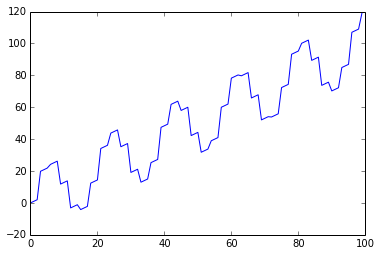

In [35]:
from scipy.fftpack import fft, ifft
plt.plot(range(len(ts_sin_lin)), np.real(ifft(fft(ts_sin_lin))))

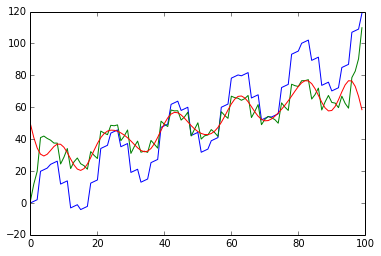

In [36]:
# Keeping low frequency 

ts_fft = fft(ts_sin_lin)
plt.plot(range(len(ts_sin_lin)), ts_sin_lin)
ts_fft[90:] = 0 # keep the only first features is 
plt.plot(range(len(ts_sin_lin)), np.real(ifft(ts_fft)))
ts_fft[10:] = 0 # keep the only first features is 
plt.plot(range(len(ts_sin_lin)), np.real(ifft(ts_fft)))


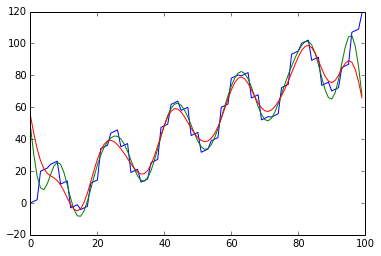

In [37]:
# Keep some few high freq  
ts_fft = fft(ts_sin_lin)
plt.plot(range(len(ts_sin_lin)), ts_sin_lin)
ts_fft[10:90] = 0 # keep some low and some high frequency (drop freq in the middle) 
plt.plot(range(len(ts_sin_lin)), np.real(ifft(ts_fft)))
ts_fft[10:95] = 0 # keep some low and some high frequency (drop freq in the middle) 
plt.plot(range(len(ts_sin_lin)), np.real(ifft(ts_fft)))